In [717]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [718]:
df_og = pd.read_csv("data/spotify_history.csv")
df = df_og.copy()
df['ts'] = pd.to_datetime(df['ts'])

In [719]:
df.loc[:, 'date'] = pd.to_datetime(df['ts']).dt.date

Let's just ignore streams before 2017 strange data.

In [720]:
df = df[df['date'] >= datetime.date(2016, 8, 1)].reset_index()

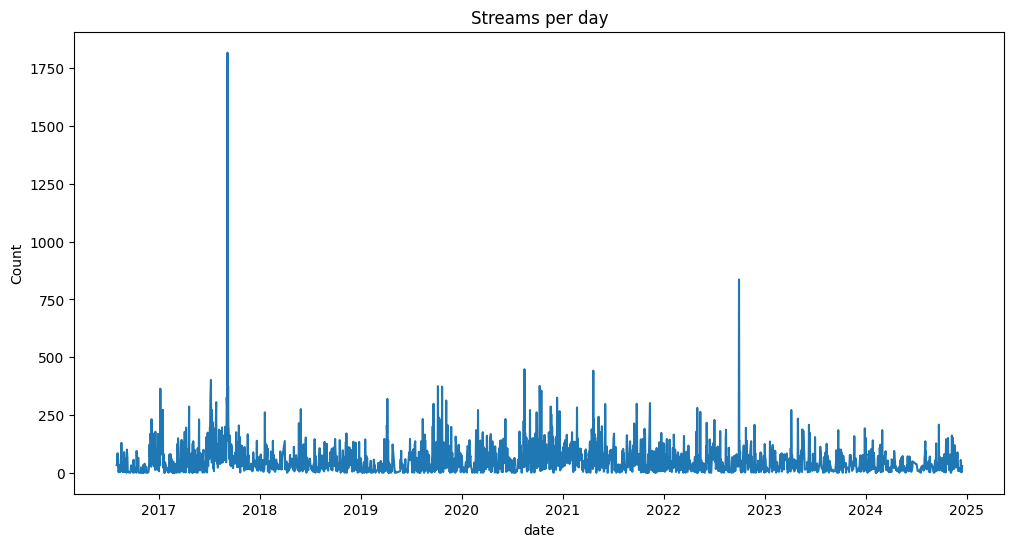

In [721]:
vc = df['date'].value_counts()
vc = vc.sort_index()

vc.plot(kind='line', figsize=(12, 6))
plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

In [722]:
t0 = df['ts'].min()
df['secs_elapsed'] = (df['ts'] - t0).dt.total_seconds()
secs_max = df['secs_elapsed'].max()
secs_3mos = 60 * 60 * 24 * 365.25 * 0.25
df['secs_elapsed'] = df['secs_elapsed'] / secs_max * secs_3mos
df['stream_end_time'] = t0 + pd.to_timedelta(df['secs_elapsed'], unit='s')
df['stream_end_date'] = df['stream_end_time'].dt.date

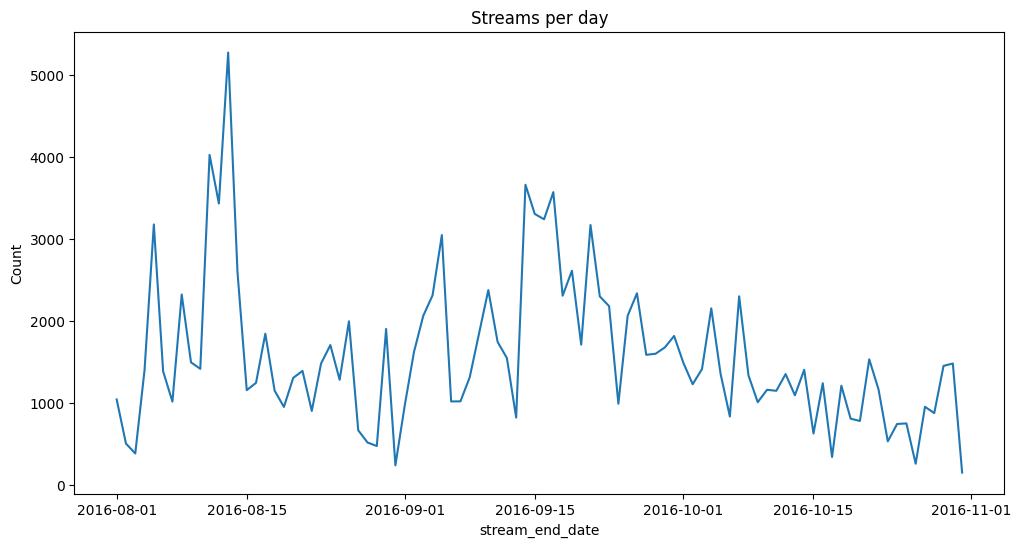

In [723]:
vc = df['stream_end_date'].value_counts()
vc = vc.sort_index()

vc.plot(kind='line', figsize=(12, 6))
plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

Top 30 artists have around 50% of total streams so we will just add botting to these and ignore the rest.

In [724]:
top_artists = df['artist_name'].value_counts().nlargest(30)
top_artists.sum() / df['artist_name'].value_counts().sum()

np.float64(0.4845340278875427)

In [725]:
N_streams = top_artists.sum()
top_artists

artist_name
The Beatles                     13543
The Killers                      6864
John Mayer                       4768
Bob Dylan                        3790
Paul McCartney                   2697
Johnny Cash                      2476
Led Zeppelin                     2426
Radiohead                        2293
The Rolling Stones               2261
The Black Keys                   2231
Pink Floyd                       2101
Imagine Dragons                  2062
The Strokes                      1808
Coldplay                         1616
Arctic Monkeys                   1594
Lou Reed                         1557
The Velvet Underground           1505
Howard Shore                     1446
Ed Sheeran                       1431
Kings of Leon                    1376
Billy Joel                       1262
John Lennon                      1214
Elvis Presley                    1153
Arcade Fire                      1136
Mumford & Sons                   1067
Ennio Morricone                   994


just keep top 30 artists

In [726]:
df = (df[df['artist_name'].isin(list(top_artists.index))])
len(df['artist_name'].unique())

30

Add in order 100 users that follow a power law of songs listened to.
Chunk data into users and maintain sessions

In [727]:
a = 3.
N_users = 300
s = np.random.zipf(a, N_users)
scaled = np.round(s / s.sum() * N_streams)

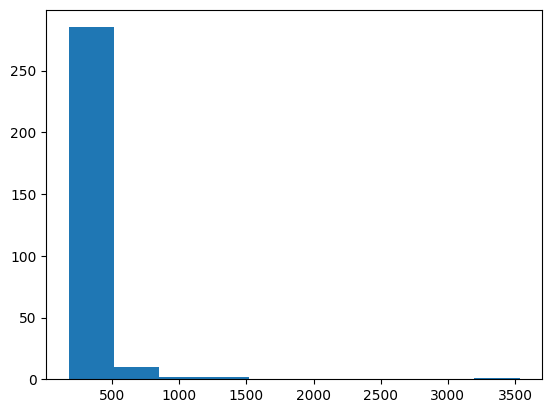

In [728]:
bins = plt.hist(scaled)

In [729]:
bin_counts = np.array([int(x) for x in bins[0]])
bin_streams = np.array([int(x) for x in bins[1][:-1]])
print(bin_counts)
print(bin_streams)
print(np.sum(bin_counts*bin_streams))

[285  10   2   2   0   0   0   0   0   1]
[ 177  512  848 1184 1519 1855 2191 2526 2862 3198]
62827


now distribute the users in each bucket for differeing streams using dirichlet prop allocation

In [730]:
alpha = 1.

proportions = [np.random.dirichlet([alpha]*int(i)) for i in bin_counts]
raw_counts = [np.floor(proportions[i] * bin_counts[i]*bin_streams[i]) for i in range(len(bin_counts))]

for i in range(len(bin_counts)):
    diff = int(bin_counts[i] * bins[1][i] - raw_counts[i].sum())
    order = np.argsort(-proportions[i])  
    for j in range(diff):
        idx = int(order[j % bin_counts[i]])  
        raw_counts[i][idx] += 1

flat_streams = [item for sublist in raw_counts for item in sublist]

In [731]:
np.sum(flat_streams)

np.float64(62834.0)

(array([246.,  40.,   7.,   4.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([   0. ,  319.8,  639.6,  959.4, 1279.2, 1599. , 1918.8, 2238.6,
        2558.4, 2878.2, 3198. ]),
 <BarContainer object of 10 artists>)

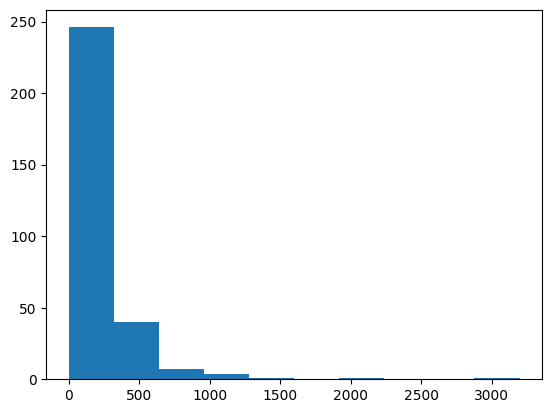

In [732]:
plt.hist(flat_streams)

i want to either run multiple separate analyses or randomize and combine analyses. also i will use the difference between the rounded number of streams and the total streams as a number of bots to inject among the users. this will have to be bounded above and below perhaps

In [733]:
N_bots = 5
N_bot_streams_tot = N_streams - np.sum(flat_streams)
N_bot_streams = np.random.randint(0, N_bot_streams_tot, size=N_bots-1)
N_bot_streams = np.sort(N_bot_streams)
N_bot_streams = np.diff([0] + N_bot_streams.tolist() + [N_bot_streams_tot])
bot_ids = [np.random.randint(0,N_users-1) for i in range(N_bots)]
print(N_bot_streams)
print(bot_ids)

[  85. 2138. 4203.  772.  474.]
[172, 64, 105, 213, 55]


create session lengths from log-normal distribution

(array([9.06e+03, 7.32e+02, 1.50e+02, 3.60e+01, 1.10e+01, 4.00e+00,
        4.00e+00, 2.00e+00, 0.00e+00, 1.00e+00]),
 array([ 1. ,  9.5, 18. , 26.5, 35. , 43.5, 52. , 60.5, 69. , 77.5, 86. ]),
 <BarContainer object of 10 artists>)

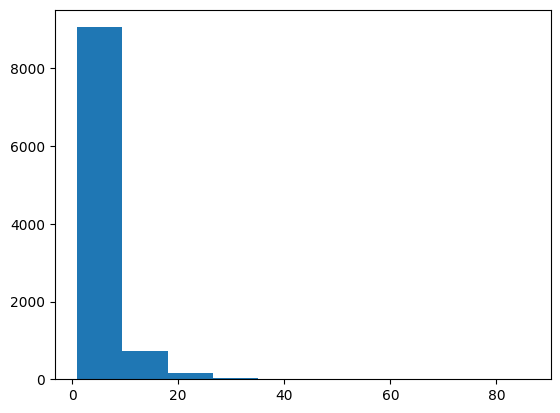

In [734]:
mean, sigma = 1., 0.9
test = 1 + np.random.lognormal(mean, sigma, 10000).astype(int)
plt.hist(test)

In [735]:
min_len = 0
max_len = 20
sessions = []

In [736]:
while sum(sessions) < N_streams:
    sesh = int(np.random.lognormal(mean, sigma))
    if sesh == 1 and np.random.rand() < 0.5:
        sesh = 1 + int(np.random.lognormal(mean, sigma))
    sesh = np.clip(sesh, min_len, max_len)
    sessions.append(sesh)

if sum(sessions) > N_streams:
    sessions[-1] -= (sum(sessions) - N_streams)

(array([4910., 6280., 3182., 1585.,  870.,  491.,  317.,  203.,  139.,
         366.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

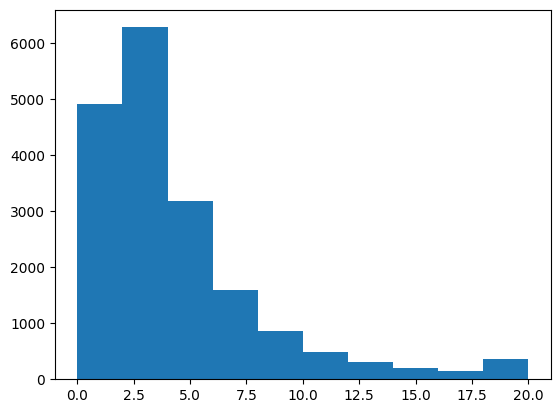

In [737]:
plt.hist(sessions)

In [738]:
session_ids = np.repeat(np.arange(len(sessions)), sessions)

now to associate sessions with users

In [739]:
remaining_streams = np.copy(flat_streams)
session_user_ids = []
final_sessions = []

for i, length in enumerate(sessions):
    possible_users = np.where(remaining_streams >= length)[0]
    if len(possible_users) == 0:
        break
    chosen = np.random.choice(possible_users)
    session_user_ids.append(chosen)
    final_sessions.append(length)
    remaining_streams[chosen] -= length

leftover_streams = []
for u, count in enumerate(remaining_streams):
    if count > 0:
        session_user_ids.extend([u] * int(count))
        final_sessions.extend([1] * int(count))


print(f"Total sessions: {len(final_sessions)}")
print(f"Sum of all session lengths: {sum(final_sessions)}")
print(f"Sum of all streams originally: {sum(flat_streams)}")

Total sessions: 16414
Sum of all session lengths: 62834
Sum of all streams originally: 62834.0


In [740]:
user_ids = np.repeat(session_user_ids, final_sessions)

In [741]:
user_ids_padded = np.pad(user_ids, (0,N_streams-len(user_ids)), constant_values=N_users)

In [742]:
df['session_id'] = session_ids
df['user_id'] = user_ids_padded

In [743]:
df.tail()

,index,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped,date,secs_elapsed,stream_end_time,stream_end_date,session_id,user_id
145507,149854,52dm9op3rbfAkc1LGXgipW,2024-12-15 23:06:18,android,1562,Wild Horses - 2009 Mix,The Rolling Stones,Sticky Fingers,fwdbtn,fwdbtn,True,True,2024-12-15,7.889400e+06,2016-10-31 10:47:27.791035002,2016-10-31,18342,300
145508,149855,4Fz1WWr5o0OrlIcZxcyZtK,2024-12-15 23:06:19,android,1247,On The Way Home,John Mayer,Paradise Valley,fwdbtn,fwdbtn,True,True,2024-12-15,7.889400e+06,2016-10-31 10:47:27.820887145,2016-10-31,18342,300
145509,149856,0qHMhBZqYb99yhX9BHcIkV,2024-12-15 23:06:21,android,1515,Magical Mystery Tour - Remastered 2009,The Beatles,Magical Mystery Tour,fwdbtn,fwdbtn,True,True,2024-12-15,7.889400e+06,2016-10-31 10:47:27.880591429,2016-10-31,18342,300
145510,149857,0HHdujGjOZChTrl8lJWEIq,2024-12-15 23:06:22,android,1283,"Stop This Train - Live at the Nokia Theatre, L...",John Mayer,Where the Light Is: John Mayer Live In Los Ang...,fwdbtn,fwdbtn,True,True,2024-12-15,7.889400e+06,2016-10-31 10:47:27.910443571,2016-10-31,18342,300
145511,149858,7peh6LUcdNPcMdrSH4JPsM,2024-12-15 23:06:23,android,1306,I Don't Trust Myself (With Loving You),John Mayer,Continuum,fwdbtn,fwdbtn,True,True,2024-12-15,7.889400e+06,2016-10-31 10:47:27.940295715,2016-10-31,18342,300


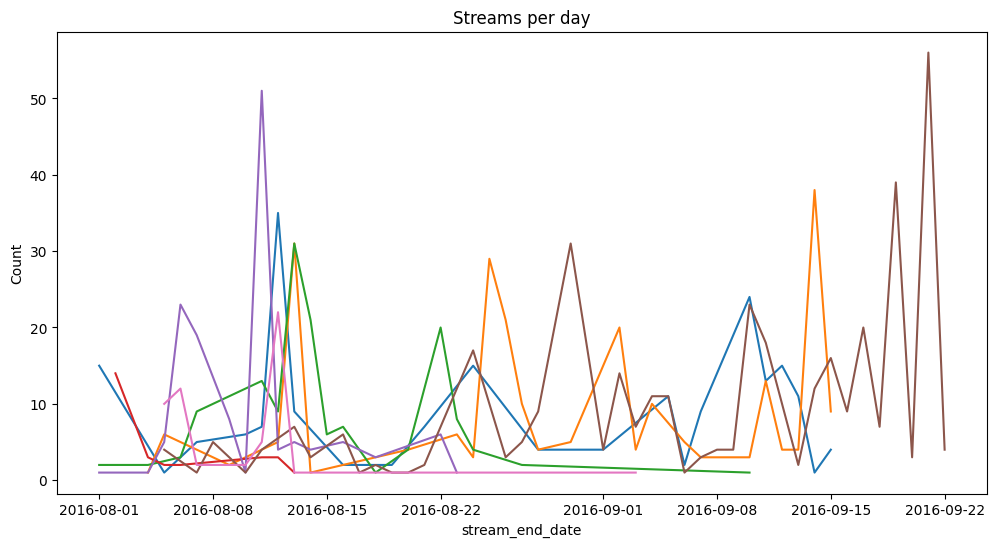

In [744]:
vc = (df[df['user_id']==0])['stream_end_date'].value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (df[df['user_id']==1])['stream_end_date'].value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (df[df['user_id']==2])['stream_end_date'].value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (df[df['user_id']==3])['stream_end_date'].value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (df[df['user_id']==4])['stream_end_date'].value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (df[df['user_id']==5])['stream_end_date'].value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

vc = (df[df['user_id']==6])['stream_end_date'].value_counts()
vc = vc.sort_index()
vc.plot(kind='line', figsize=(12, 6))

plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

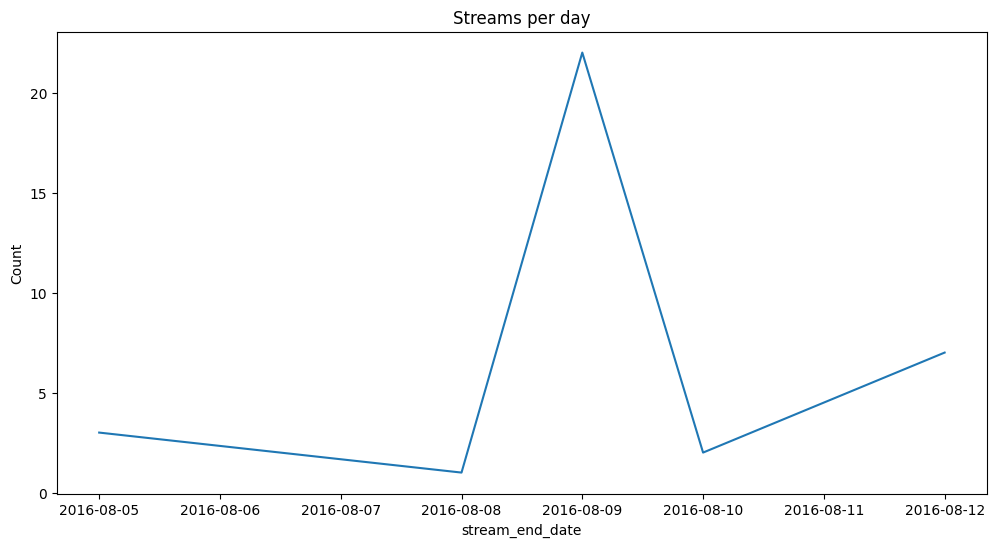

In [745]:

vc = (df[df['user_id']==200])['stream_end_date'].value_counts()
vc = vc.sort_index()

vc.plot(kind='line', figsize=(12, 6))
plt.ylabel('Count')
plt.title('Streams per day')
plt.show()